In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import imageio
import cv2
import numpy as np
import pandas as pd
import os
import pickle
import re
from PIL import Image


CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "standing",
    "walking",
    "breaking"
]


### Extracting Spatio temporal features from videos

In [ ]:
import os

def extracting_features():

    data = []

    path = "drive/MyDrive/atm"
    for filepath in os.listdir(path):
        
        category = filepath.split("_")[1]

        filepath = os.path.join(path,filepath)
        vid = imageio.get_reader(filepath, "ffmpeg")

        frames = []

        # Add each frame to correct list.
        for i, frame in enumerate(vid):

            frame = cv2.resize(frame,(120,160))

            # Convert to grayscale.
            frame = Image.fromarray(np.array(frame))
            frame = frame.convert("L")
            frame = np.array(frame.getdata(),
                            dtype=np.float32).reshape((120, 160))
            frame = np.array(Image.fromarray(frame).resize((12, 32)))

            frames.append(frame)

        data.append({
            "filename": filepath,
            "category": category,
            "frames": frames    
        })

    pickle.dump(data, open("train.p", "wb"))

extracting_features()

/usr/local/lib/python3.7/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/drive/MyDrive/atm_hind_ece/person01_standing_d1_uncomp.avi.
  warn("Could not read last frame of %s." % uri)


In [ ]:
train = pickle.load(open("/content/drive/MyDrive/ATM_project/train.p", "rb"))

In [ ]:
train_fea = []
for i in train:
    for j in i["frames"]:
        train_fea.append(j)

train_fea = np.array(train_fea).reshape(-1,384)

from sklearn.preprocessing import minmax_scale
train_fea = minmax_scale(train_fea-train_fea.mean(), feature_range=(-1,1))

train_fea = pd.DataFrame(train_fea[:4366])
print(train_fea.shape)

(4366, 384)


### Extracting Optical flow Features from videos

In [ ]:
def make_optflow_dataset(dataset="train"):

    # Setup parameters for optical flow.
    farneback_params = dict(
        winsize=20, iterations=1,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)

    data = []

    path = "drive/MyDrive/atm"

    for filename in os.listdir(path):

        filepath = os.path.join(path, filename)
        category = filename.split("_")[1]

        vid = imageio.get_reader(filepath, "ffmpeg")

        flow_x = []
        flow_y = []

        prev_frame = None
        # Add each frame to correct list.
        for i, frame in enumerate(vid):
            
            frame = cv2.resize(frame,(120,160))

            # Convert to grayscale.
            frames = Image.fromarray(np.array(frame))
            frames = frames.convert("L")
            frames = np.array(frames.getdata(),
                                dtype=np.float32).reshape((120, 160))
            frames = np.array(Image.fromarray(frames).resize((60, 80)))
            #print(frame.shape[1])
            #print(frame.shape[0])
            if prev_frame is not None:
                # Calculate optical flow.
                flows = cv2.calcOpticalFlowFarneback(prev_frame, frames, **farneback_params)
                
                
                subsampled_x = np.zeros((32, 12), dtype=np.float32)
                subsampled_y = np.zeros((32, 12), dtype=np.float32)
                # print(subsampled_x)
                for r in range(32):
                    for c in range(12):
                        subsampled_x[r, c] = flows[r*2, c*2, 0]
                        subsampled_y[r, c] = flows[r*2, c*2, 1]
                            
                flow_x.append(subsampled_x)
                flow_y.append(subsampled_y)

            prev_frame = frames

        data.append({
            "filename": filename,
            "category": category,
            "flow_x": flow_x,
            "flow_y": flow_y    
        })

    pickle.dump(data, open("%s_flow.p" % dataset, "wb"))

make_optflow_dataset(dataset="train")

/usr/local/lib/python3.7/dist-packages/imageio/core/format.py:411: UserWarning: Could not read last frame of /content/drive/MyDrive/atm_hind_ece/person01_standing_d1_uncomp.avi.
  warn("Could not read last frame of %s." % uri)


In [ ]:
train_flow = pickle.load(open("/content/drive/MyDrive/ATM_project/train_flow.p", "rb"))

In [ ]:
train_flowx_fea = []
for i in train_flow:
    for j in i["flow_x"]:
        train_flowx_fea.append(j)

train_flowx_fea = np.array(train_flowx_fea).reshape(-1,384)
print(train_flowx_fea.shape)
train_flowx_fea = minmax_scale(train_flowx_fea-train_flowx_fea.mean(), feature_range=(-1,1))
train_flowx_fea = pd.DataFrame(train_flowx_fea)


train_flowy_fea = []
for i in train_flow:
    for j in i["flow_y"]:
        train_flowy_fea.append(j)

train_flowy_fea = np.array(train_flowy_fea).reshape(-1,384)
print(train_flowy_fea.shape)
train_flowy_fea = minmax_scale(train_flowy_fea-train_flowy_fea.mean(), feature_range=(-1,1))
train_flowy_fea = pd.DataFrame(train_flowy_fea)

(74481, 384)
(74481, 384)


In [ ]:
df = pd.concat([train_fea, train_flowx_fea[:4366], train_flowy_fea[:4366]], axis=1, ignore_index=True)

In [ ]:
wal = list(range(554))
box = list(range(554, 913))
cla = list(range(913, 1290))
wav = list(range(1290, 1757))
sta = list(range(1757, 4095))
bre = list(range(4095, 4366))

df.loc[wal,'label'] = "0"
df.loc[box,'label'] = "1"
df.loc[cla,'label'] = "2"
df.loc[wav,'label'] = "3"
df.loc[sta,'label'] = "4"
df.loc[bre,'label'] = "5"

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,label
0,-0.117016,-0.024667,-0.083134,-0.109433,-0.109799,-0.072812,-0.092027,-0.131819,-0.121422,-0.098336,...,-0.148949,-0.081781,-0.007279,0.023949,0.009853,-0.024823,-0.129532,-0.091128,-0.004777,0
1,-0.117016,-0.024667,-0.083134,-0.109433,-0.109799,-0.072812,-0.092027,-0.131819,-0.121422,-0.098336,...,-0.157563,-0.088053,-0.010975,0.022333,0.009200,-0.028131,-0.139699,-0.109377,-0.029472,0
2,-0.117016,-0.024667,-0.083134,-0.109433,-0.109799,-0.072812,-0.092027,-0.131819,-0.121422,-0.098336,...,-0.156063,-0.087787,-0.011644,0.021337,0.008861,-0.026137,-0.139294,-0.121831,-0.059692,0
3,-0.117016,-0.024667,-0.083237,-0.108179,-0.104673,-0.069217,-0.088869,-0.128391,-0.116778,-0.094159,...,-0.163130,-0.093499,-0.015433,0.018858,0.006215,-0.029425,-0.145178,-0.132246,-0.068895,0
4,-0.117104,-0.021963,-0.078960,-0.103843,-0.101706,-0.069094,-0.088039,-0.128167,-0.119382,-0.096140,...,-0.155292,-0.086863,-0.010483,0.022359,0.008800,-0.027346,-0.138405,-0.112224,-0.039859,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361,0.784955,0.870643,0.872905,0.897233,0.909031,0.885149,0.893145,0.908954,0.900466,0.908788,...,-0.112058,-0.037505,0.046784,0.085562,0.069726,0.031115,-0.085187,-0.066387,0.003436,5
4362,0.792639,0.870346,0.872571,0.895844,0.909109,0.885144,0.893146,0.908957,0.900432,0.908780,...,-0.044608,0.035599,0.106449,0.128536,0.105664,0.067415,-0.054929,-0.043339,0.035569,5
4363,0.792639,0.870346,0.872797,0.893108,0.907665,0.885299,0.893141,0.908957,0.900432,0.908780,...,-0.093544,-0.028047,0.042147,0.068336,0.043489,-0.006036,-0.132103,-0.115967,-0.033921,5
4364,0.792488,0.870509,0.874127,0.894660,0.907569,0.885429,0.895378,0.912496,0.902949,0.909041,...,-0.100455,-0.011935,0.089031,0.141892,0.124216,0.071809,-0.059374,-0.041610,0.043263,5


In [ ]:
X = df.iloc[:, :-1]
Y = df.iloc[:,-1]

from keras.utils import np_utils
Y = np_utils.to_categorical(Y)

print(X.shape)
print(Y.shape)

(4366, 1152)
(4366, 6)


### Clusterization using triple stacked autoencoders

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.python.keras import regularizers

batch_size = 32
input_dim = 1152 #num of predictor variables
learning_rate = 1e-5
input_layer = Input(shape=(input_dim, ), name="input")
#Input Layer
encoder = Dense (2000, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
#Encoder’s first dense layer
encoder = Dense (1000, activation="relu",
activity_regularizer=regularizers.l1(learning_rate))(encoder)
#Encoder’s second dense layer
encoder = Dense (500, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(encoder)
# Code layer
encoder = Dense (200, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(encoder)
# Decoder’s first dense layer
decoder = Dense(500, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(encoder)
# Decoder’s second dense layer
decoder = Dense(1000, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(decoder)
# Decoder’s Third dense layer
decoder = Dense(2000, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(decoder)
# Output Layer
decoder = Dense(input_dim, activation="sigmoid", activity_regularizer=regularizers.l1(learning_rate))(decoder)

autoencoder_1 = Model(inputs=input_layer, outputs=decoder)
autoencoder_1.compile(loss='mean_squared_error',optimizer='adam')
stack_1 = autoencoder_1.fit(X, X,epochs=20,batch_size=batch_size)

autoencoder_2_input = autoencoder_1.predict(X)
autoencoder_2_input = np.concatenate((autoencoder_2_input , X))

autoencoder_2 = Model(inputs=input_layer, outputs=decoder)
autoencoder_2.compile(loss='mean_squared_error',optimizer='adam')
stack_2 = autoencoder_2.fit(autoencoder_2_input, autoencoder_2_input,epochs=10,batch_size=batch_size)

autoencoder_3_input = autoencoder_2.predict(autoencoder_2_input)
autoencoder_3_input = np.concatenate((autoencoder_3_input, autoencoder_2_input))\

autoencoder_3 = Model(inputs=input_layer, outputs=decoder)
autoencoder_3.compile(loss='mean_squared_error', optimizer='adam')
stack_3 = autoencoder_3.fit(autoencoder_3_input, autoencoder_3_input, epochs=5, batch_size=16)


Epoch 1/20
137/137 [==============================] - 4s 7ms/step - loss: 0.0360
Epoch 2/20
137/137 [==============================] - 2s 11ms/step - loss: 0.0183
Epoch 3/20
137/137 [==============================] - 1s 10ms/step - loss: 0.0166
Epoch 4/20
137/137 [==============================] - 1s 9ms/step - loss: 0.0156
Epoch 5/20
137/137 [==============================] - 1s 10ms/step - loss: 0.0149
Epoch 6/20
137/137 [==============================] - 1s 9ms/step - loss: 0.0144
Epoch 7/20
137/137 [==============================] - 1s 6ms/step - loss: 0.0140
Epoch 8/20
137/137 [==============================] - 1s 6ms/step - loss: 0.0136
Epoch 9/20
137/137 [==============================] - 1s 6ms/step - loss: 0.0133
Epoch 10/20
137/137 [==============================] - 1s 6ms/step - loss: 0.0130
Epoch 11/20
137/137 [==============================] - 1s 6ms/step - loss: 0.0128
Epoch 12/20
137/137 [==============================] - 1s 6ms/step - loss: 0.0126
Epoch 13/20
137/137 [=

### Make BoW vector for every video frame

In [ ]:
import argparse
import numpy as np
import os
import pickle

from scipy.cluster.vq import vq

def make_bow(dataset, clusters, tfidf):
    print("Make bow vector for each frame")

    # Count total number of frames.
    n_frames = len(dataset)

    # Init bow vectors for all frames.
    bow = np.zeros((n_frames, clusters.shape[1]), dtype=np.float)

    # Check whether to use TF-IDF weighting.
    if tfidf:
        print("Applying TF-IDF weighting")
        freq = np.sum((bow > 0) * 1, axis = 0)
        idf = np.log((n_frames + 1) / (freq + 1))
        bow = dataset * idf

    return bow

if __name__ == "__main__":

    tfidf = 1

    # Load clusters.
    clusters = X

    # Load dataset.
    dataset = X

    # Make bow vectors.
    dataset_bow = make_bow(dataset, clusters, tfidf)


Make bow vector for each frame
Applying TF-IDF weighting


<ipython-input-28-12049ae9747a>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bow = np.zeros((n_frames, clusters.shape[1]), dtype=np.float)


### VGG

In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 10% for testing
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(dataset_bow, Y,
	test_size=0.1, random_state=42)


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Flatten, Bidirectional, LSTM, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
import tensorflow as tf


def Conv_1D_Block(x, model_width, kernel, strides):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, strides=strides, padding="same", kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


def stem(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs : input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(conv)
    
    return pool


def conv_block(inputs, num_filters):
    # Construct Block of Convolutions without Pooling
    # x        : input into the block
    # n_filters: number of filters
    conv = Conv_1D_Block(inputs, num_filters, 3, 2)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    
    return conv


def residual_block(inputs, num_filters):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = inputs
    #
    conv = Conv_1D_Block(inputs, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)
    
    return out


def residual_group(inputs, num_filters, n_blocks, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for i in range(n_blocks):
        out = residual_block(out, num_filters)

    # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)
    
    return out


def stem_bottleneck(inputs, num_filters):
    # Construct the Stem Convolution Group
    # inputs :input vector
    # First Convolutional layer, where pooled feature maps will be reduced by 75%
    conv = Conv_1D_Block(inputs, num_filters, 7, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(conv)
    
    return pool


def residual_block_bottleneck(inputs, num_filters):
    # Construct a Residual Block of Convolutions
    # x        : input into the block
    # n_filters: number of filters
    shortcut = Conv_1D_Block(inputs, num_filters * 4, 1, 1)
    #
    conv = Conv_1D_Block(inputs, num_filters, 1, 1)
    conv = Conv_1D_Block(conv, num_filters, 3, 1)
    conv = Conv_1D_Block(conv, num_filters * 4, 1, 1)
    conv = tf.keras.layers.Add()([conv, shortcut])
    out = tf.keras.layers.Activation('relu')(conv)

    return out


def residual_group_bottleneck(inputs, num_filters, n_blocks, conv=True):
    # x        : input to the group
    # n_filters: number of filters
    # n_blocks : number of blocks in the group
    # conv     : flag to include the convolution block connector
    out = inputs
    for i in range(n_blocks):
        out = residual_block_bottleneck(out, num_filters)

    # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
    if conv:
        out = conv_block(out, num_filters * 2)

    return out



def learner50(inputs, num_filters):
    # Construct the Learner
    x = residual_group_bottleneck(inputs, num_filters, 3)  # First Residual Block Group of 64 filters
    x = residual_group_bottleneck(x, num_filters * 2, 3)   # Second Residual Block Group of 128 filters
    x = residual_group_bottleneck(x, num_filters * 4, 5)   # Third Residual Block Group of 256 filters
    out = residual_group_bottleneck(x, num_filters * 8, 2, False)  # Fourth Residual Block Group of 512 filters
    
    return out







def classifier(inputs, class_number):
    # Construct the Classifier Group
    # inputs       : input vector
    # class_number : number of output classes
    out = tf.keras.layers.Dense(class_number, activation='softmax')(inputs)
    
    return out


def regressor(inputs, feature_number):
    # Construct the Regressor Group
    # inputs       : input vector
    # feature_number : number of output features
    out = tf.keras.layers.Dense(feature_number, activation='linear')(inputs)
    
    return out


class ResNet:
    def __init__(self, length, num_channel, num_filters, problem_type='classification',
                 output_nums=1, pooling='avg', dropout_rate=False):
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.pooling = pooling
        self.dropout_rate = dropout_rate

    def MLP(self, x):
        if self.pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif self.pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        # Final Dense Outputting Layer for the outputs
        x = tf.keras.layers.Flatten(name='flatten')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        return outputs


    def ResNet50(self):
        inputs = tf.keras.Input((self.length, self.num_channel))     # The input tensor
        stem_b = stem_bottleneck(inputs, self.num_filters)  # The Stem Convolution Group
        x = learner50(stem_b, self.num_filters)             # The learner
        outputs = self.MLP(x)
        # Instantiate the Model
        model = tf.keras.Model(inputs, outputs)

        return model
   

In [ ]:
Model = ResNet(length=1152, num_channel=1, num_filters=16, problem_type="Classification", output_nums=6, dropout_rate=0.25).ResNet50()
Model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=["accuracy"])
Model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1152, 1)]    0           []                               
                                                                                                  
 conv1d_119 (Conv1D)            (None, 576, 16)      128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_118 (Batch  (None, 576, 16)     64          ['conv1d_119[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_144 (Activation)    (None, 576, 16)      0           ['batch_normalization_118[0

In [ ]:
checkpoint_filepath="/content/drive/MyDrive/ATM_project/model_weight.h5"
checkpointer = ModelCheckpoint(checkpoint_filepath,monitor='val_accuracy',mode='max',verbose=1, save_best_only=True)
hist = Model.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, Y_test),callbacks = [checkpointer])

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.5482
Epoch 1: val_accuracy improved from -inf to 0.53547, saving model to /content/drive/MyDrive/ATM_project/model_weight.h5
123/123 [==============================] - 9s 76ms/step - loss: 1.2336 - accuracy: 0.5482 - val_loss: 1.2656 - val_accuracy: 0.5355
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 1.0842 - accuracy: 0.5920
Epoch 2: val_accuracy improved from 0.53547 to 0.55835, saving model to /content/drive/MyDrive/ATM_project/model_weight.h5
123/123 [==============================] - 8s 68ms/step - loss: 1.0842 - accuracy: 0.5920 - val_loss: 1.2200 - val_accuracy: 0.5584
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.6297
Epoch 3: val_accuracy did not improve from 0.55835
123/123 [==============================] - 8s 62ms/step - loss: 0.9737 - accuracy: 0.6297 - val_loss: 1.0973 - val_accuracy: 0.5446
Epoch 4/20
123/123 [==

In [ ]:
from sklearn.metrics import classification_report
model  = load_model("/content/drive/MyDrive/ATM_project/model_weight.h5")
Y_pred = model.predict(X_test)
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=['walking', 'boxing', 'handclapping', 'handwaving', 'standing', 'breaking']))

14/14 [==============================] - 2s 15ms/step
              precision    recall  f1-score   support

     walking       1.00      0.94      0.97        70
      boxing       0.83      0.92      0.87        37
handclapping       0.90      0.90      0.90        41
  handwaving       1.00      1.00      1.00        55
    standing       0.99      0.98      0.98       207
    breaking       0.89      0.93      0.91        27

    accuracy                           0.96       437
   macro avg       0.94      0.95      0.94       437
weighted avg       0.96      0.96      0.96       437



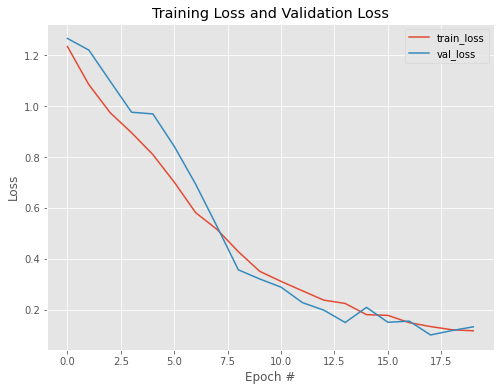

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 20), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), hist.history["val_loss"], label="val_loss")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()

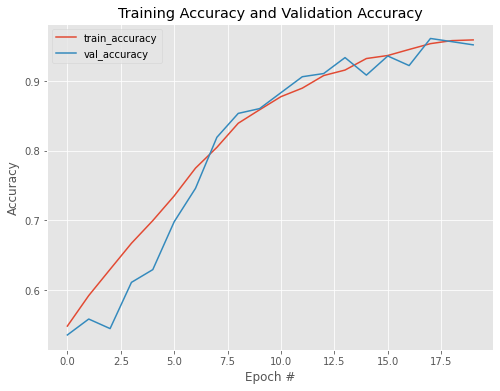

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 20), hist.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 20), hist.history["val_accuracy"], label="val_accuracy")
plt.title("Training Accuracy and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.show()

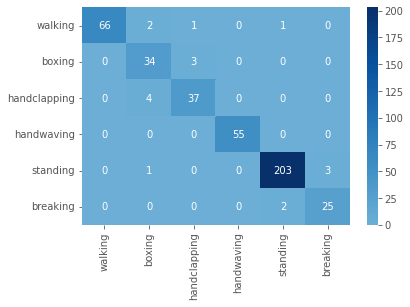

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['walking', 'boxing', 'handclapping', 'handwaving', 'standing', 'breaking']
CM = confusion_matrix(Y_test.argmax(axis=1),
	Y_pred.argmax(axis=1))
# drawing confusion matrix
sns.heatmap(CM, center = True , annot=True, fmt="d" ,cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.show()